In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
#from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import ResNet101
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

Using TensorFlow backend.


In [2]:
#identify GPU
device_name = tf.test.gpu_device_name()
if not tf.test.is_gpu_available():
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
tf.config.list_physical_devices('GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Found GPU at: /device:GPU:0


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_again', 'X_train.npy'))
    labels = np.load(os.path.join('Data_again', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_again', 'X_test.npy'))
    labels = np.load(os.path.join('Data_again', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [4]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 255
test_images = test_images.astype('uint16') / 255

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2913 	 Test size: 655
Image size: 256x256


In [5]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_resnet101(verbose=False, fc_size=256, dropout=None):
    
    resnet101_base = ResNet101(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    resnet101 = models.Sequential()
    resnet101.add(resnet101_base)

    resnet101.add(layers.Flatten())
    if dropout is not None:
        resnet101.add(layers.Dropout(dropout))
    resnet101.add(layers.Dense(fc_size, activation='relu'))
    resnet101.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    resnet101_base.trainable = False
    
    if verbose:
        resnet101_base.summary()
        resnet101.summary()

    return resnet101

In [22]:
resnet101_fe_drop_temp = create_resnet101(verbose=True, dropout=0.5, fc_size=256)

Model: "resnet101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________________________________________________________________________

In [6]:
# Instantiate a VGG19 network with custom final layer
resnet101_fe_drop_128 = create_resnet101(dropout=0.5, fc_size=128)

In [7]:
resnet101_fe_drop_128.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 8, 8, 2048)        42658176  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               16777344  
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 59,436,036
Trainable params: 16,777,860
Non-trainable params: 42,658,176
_________________________________________________________________


In [8]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('resnet101_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
resnet101_fe_drop_128.compile(optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
# Train
history_resnet101_fe_drop_128 = resnet101_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 2.3415 - accuracy: 0.3236
Epoch 00001: val_loss improved from inf to 1.33712, saving model to resnet101_fe_drop_128_4cl_best.h5
19/19 [==============================] - 35s 2s/step - loss: 2.3253 - accuracy: 0.3265 - val_loss: 1.3371 - val_accuracy: 0.4038
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.6469 - accuracy: 0.3967
Epoch 00002: val_loss improved from 1.33712 to 1.27729, saving model to resnet101_fe_drop_128_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 1.6347 - accuracy: 0.3985 - val_loss: 1.2773 - val_accuracy: 0.4210
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3823 - accuracy: 0.4222
Epoch 00003: val_loss improved from 1.27729 to 1.22104, saving model to resnet101_

Epoch 27/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0148 - accuracy: 0.5365
Epoch 00027: val_loss improved from 1.07434 to 1.06089, saving model to resnet101_fe_drop_128_4cl_best.h5
19/19 [==============================] - 30s 2s/step - loss: 0.9981 - accuracy: 0.5388 - val_loss: 1.0609 - val_accuracy: 0.5120
Epoch 28/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9930 - accuracy: 0.5402
Epoch 00028: val_loss did not improve from 1.06089
19/19 [==============================] - 30s 2s/step - loss: 0.9953 - accuracy: 0.5405 - val_loss: 1.0816 - val_accuracy: 0.5189
Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9756 - accuracy: 0.5483
Epoch 00029: val_loss did not improve from 1.06089
19/19 [==============================] - 30s 2s/step - loss: 0.9792 - accuracy: 0.5465 - val_loss: 1.0908 - val_accuracy: 0.4914
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9828 - accuracy: 0.5583
Epoch 00030: val_loss

Epoch 86/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8863 - accuracy: 0.5937
Epoch 00086: val_loss did not improve from 1.04633
19/19 [==============================] - 30s 2s/step - loss: 0.8811 - accuracy: 0.5955 - val_loss: 1.0687 - val_accuracy: 0.4914
Epoch 87/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8781 - accuracy: 0.5937
Epoch 00087: val_loss did not improve from 1.04633
19/19 [==============================] - 30s 2s/step - loss: 0.8738 - accuracy: 0.5963 - val_loss: 1.0759 - val_accuracy: 0.4725
Epoch 88/200
18/19 [===========================>..] - ETA: 1s - loss: 0.9110 - accuracy: 0.5869
Epoch 00088: val_loss did not improve from 1.04633
19/19 [==============================] - 30s 2s/step - loss: 0.9166 - accuracy: 0.5834 - val_loss: 1.0516 - val_accuracy: 0.5052
Epoch 89/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8776 - accuracy: 0.5983
Epoch 00089: val_loss improved from 1.04633 to 1.02728, saving model to resn

Epoch 116/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8520 - accuracy: 0.6083
Epoch 00116: val_loss did not improve from 1.02728
19/19 [==============================] - 30s 2s/step - loss: 0.8521 - accuracy: 0.6113 - val_loss: 1.0743 - val_accuracy: 0.4897
Epoch 117/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8558 - accuracy: 0.6187
Epoch 00117: val_loss did not improve from 1.02728
19/19 [==============================] - 30s 2s/step - loss: 0.8596 - accuracy: 0.6203 - val_loss: 1.0965 - val_accuracy: 0.5017
Epoch 118/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8425 - accuracy: 0.6173
Epoch 00118: val_loss did not improve from 1.02728
19/19 [==============================] - 30s 2s/step - loss: 0.8400 - accuracy: 0.6216 - val_loss: 1.0573 - val_accuracy: 0.5172
Epoch 119/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8547 - accuracy: 0.6015
Epoch 00119: val_loss did not improve from 1.02728
19/19 [==============

In [10]:
# Save
models.save_model(resnet101_fe_drop_128, 'resnet101_fe_drop_128_4cl_end.h5')

In [11]:
# History of accuracy and loss
tra_loss_fe = history_resnet101_fe_drop_128.history['loss']
tra_acc_fe = history_resnet101_fe_drop_128.history['accuracy']
val_loss_fe = history_resnet101_fe_drop_128.history['val_loss']
val_acc_fe = history_resnet101_fe_drop_128.history['val_accuracy']

In [12]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_fe_drop_128 = models.load_model('resnet101_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet101_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [13]:
print("resnet101 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 119
Epoch [opt]: 89
Valid accuracy [end]: 0.5017
Valid accuracy [opt]: 0.5017
Test accuracy [end]:  0.4885
Test accuracy [opt]:  0.4885
Valid loss [end]: 1.0420
Valid loss [opt]: 1.0273
Test loss [end]:  1.1188
Test loss [opt]:  1.1255


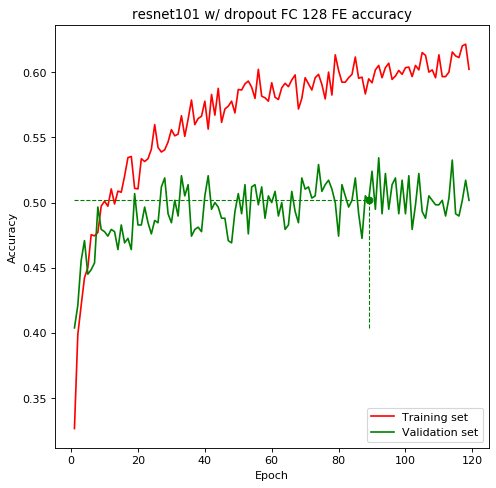

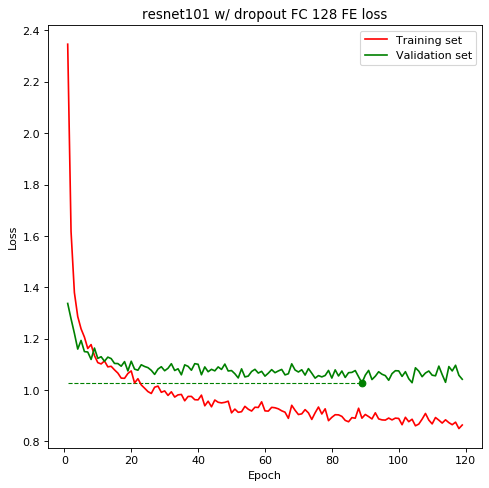

In [14]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [15]:
# Instantiate a VGG19 network with custom final layer
resnet101_fe_drop_256 = create_resnet101(dropout=0.5, fc_size=256)

# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('resnet101_fe_drop_256_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
resnet101_fe_drop_256.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Train
history_resnet101_fe_drop_256 = resnet101_fe_drop_256.fit_generator(
        train_generator,
        epochs=150,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/150
18/19 [===========================>..] - ETA: 1s - loss: 34.4717 - accuracy: 0.3591
Epoch 00001: val_loss improved from inf to 1.22185, saving model to resnet101_fe_drop_256_4cl_best.h5
19/19 [==============================] - 34s 2s/step - loss: 32.3323 - accuracy: 0.3642 - val_loss: 1.2219 - val_accuracy: 0.3935
Epoch 2/150
18/19 [===========================>..] - ETA: 1s - loss: 1.2157 - accuracy: 0.4258
Epoch 00002: val_loss improved from 1.22185 to 1.20512, saving model to resnet101_fe_drop_256_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 1.2157 - accuracy: 0.4234 - val_loss: 1.2051 - val_accuracy: 0.3935
Epoch 3/150
18/19 [===========================>..] - ETA: 1s - loss: 1.1648 - accuracy: 0.4626
Epoch 00003: val_loss improved from 1.20512 to 1.18092, saving model to resnet101_fe_drop_256_4cl_best.h5
19/19 [==============================] - 31s 2s/st

Epoch 29/150
18/19 [===========================>..] - ETA: 1s - loss: 0.8911 - accuracy: 0.6105
Epoch 00029: val_loss improved from 1.09363 to 1.08849, saving model to resnet101_fe_drop_256_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 0.8993 - accuracy: 0.6079 - val_loss: 1.0885 - val_accuracy: 0.5309
Epoch 30/150
18/19 [===========================>..] - ETA: 1s - loss: 0.8793 - accuracy: 0.6087
Epoch 00030: val_loss did not improve from 1.08849
19/19 [==============================] - 30s 2s/step - loss: 0.8814 - accuracy: 0.6096 - val_loss: 1.1371 - val_accuracy: 0.5498
Epoch 31/150
18/19 [===========================>..] - ETA: 1s - loss: 0.8758 - accuracy: 0.6060
Epoch 00031: val_loss improved from 1.08849 to 1.05886, saving model to resnet101_fe_drop_256_4cl_best.h5
19/19 [==============================] - 31s 2s/step - loss: 0.8827 - accuracy: 0.6036 - val_loss: 1.0589 - val_accuracy: 0.5344
Epoch 32/150
18/19 [===========================>..] - ETA: 1s 

In [20]:
# Save
models.save_model(resnet101_fe_drop_256, 'resnet101_fe_drop_256_4cl_end.h5')

In [21]:
# History of accuracy and loss
tra_loss_fe = history_resnet101_fe_drop_256.history['loss']
tra_acc_fe = history_resnet101_fe_drop_256.history['accuracy']
val_loss_fe = history_resnet101_fe_drop_256.history['val_loss']
val_acc_fe = history_resnet101_fe_drop_256.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_fe_drop_256 = models.load_model('resnet101_fe_drop_256_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet101_fe_drop_256.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_fe_drop_256.evaluate(test_images, test_labels, verbose=False)

print("Resnet101 (w/ dropout) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

Resnet101 (w/ dropout) Feature Extraction

Epoch [end]: 61
Epoch [opt]: 31
Valid accuracy [end]: 0.5103
Valid accuracy [opt]: 0.5344
Test accuracy [end]:  0.4718
Test accuracy [opt]:  0.5099
Valid loss [end]: 1.2035
Valid loss [opt]: 1.0589
Test loss [end]:  1.5204
Test loss [opt]:  1.2347


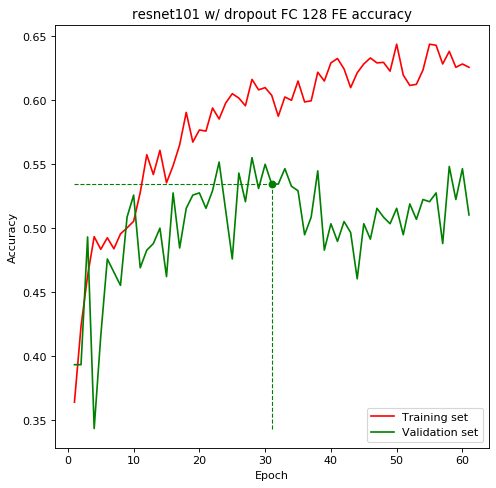

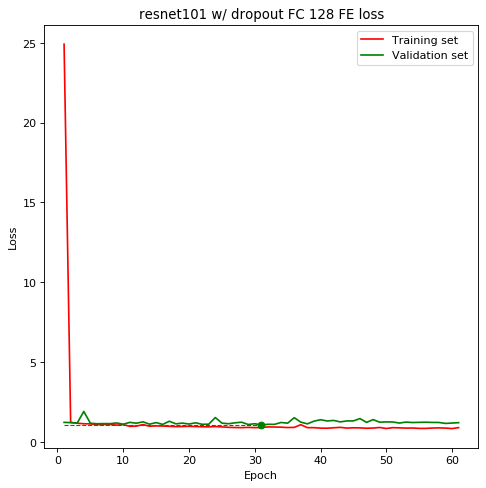

In [22]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();

In [23]:
models.load_model('resnet101_fe_drop_256_4cl_best.h5').summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 8, 8, 2048)        42658176  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 76,213,892
Trainable params: 33,555,716
Non-trainable params: 42,658,176
_________________________________________________________________


In [6]:
resnet101_ft_1layer = models.load_model('resnet101_fe_drop_256_4cl_best.h5')
# Fine tuning: unfreeze the last convolutional layer
for layer in resnet101_ft_1layer.get_layer('resnet101').layers[-10:]:
    print(layer.name)
    layer.trainable = True

# Recompile the model ()
resnet101_ft_1layer.compile(optimizer=RMSprop(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

resnet101_ft_1layer.summary()
resnet101_ft_1layer.get_layer('resnet101').summary()

conv5_block3_1_conv
conv5_block3_1_bn
conv5_block3_1_relu
conv5_block3_2_conv
conv5_block3_2_bn
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet101 (Model)            (None, 8, 8, 2048)        42658176  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 131072)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33554688  
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 76,213,892
Trainable params: 38,021,380
Non-traina

In [7]:
# Callback for early-stopping
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint(
        'resnet101_ft_1layer_4cl_best.h5',
        monitor='val_loss',
        mode='min',
        verbose=1, 
        save_best_only=True, 
        save_freq='epoch')

In [8]:
# Train
history_ft = resnet101_ft_1layer.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[early_stop, checkpoint],
        shuffle=True,
        verbose=1,
        initial_epoch=0)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8566 - accuracy: 0.6219
Epoch 00001: val_loss improved from inf to 1.09668, saving model to resnet101_ft_1layer_4cl_best.h5
19/19 [==============================] - 36s 2s/step - loss: 0.8503 - accuracy: 0.6251 - val_loss: 1.0967 - val_accuracy: 0.5241
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8450 - accuracy: 0.6273
Epoch 00002: val_loss did not improve from 1.09668
19/19 [==============================] - 30s 2s/step - loss: 0.8492 - accuracy: 0.6268 - val_loss: 1.2907 - val_accuracy: 0.5000
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 0.8089 - accuracy: 0.6523
Epoch 00003: val_loss did not improve from 1.09668
19/19 [==============================] - 30s 2s/step - loss: 0.8112 - accuracy: 0.6495 -

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6954 - accuracy: 0.6968
Epoch 00029: val_loss did not improve from 1.09668
19/19 [==============================] - 30s 2s/step - loss: 0.7031 - accuracy: 0.6928 - val_loss: 6.7703 - val_accuracy: 0.4244
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6995 - accuracy: 0.6850
Epoch 00030: val_loss did not improve from 1.09668
19/19 [==============================] - 30s 2s/step - loss: 0.6965 - accuracy: 0.6860 - val_loss: 7.2523 - val_accuracy: 0.4261
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 0.6986 - accuracy: 0.6877
Epoch 00031: val_loss did not improve from 1.09668
19/19 [==============================] - 30s 2s/step - loss: 0.7065 - accuracy: 0.6864 - val_loss: 7.1229 - val_accuracy: 0.4210
Epoch 00031: early stopping


In [9]:
# Save
models.save_model(resnet101_ft_1layer, 'resnet101_ft_1layer_4cl_end.h5')

In [10]:
# History of accuracy and loss
tra_loss_fe = history_ft.history['loss']
tra_acc_fe = history_ft.history['accuracy']
val_loss_fe = history_ft.history['val_loss']
val_acc_fe = history_ft.history['val_accuracy']

# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_resnet101_ft_1layer = models.load_model('resnet101_ft_1layer_4cl_best.h5')
test_loss_fe, test_acc_fe = resnet101_ft_1layer.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_resnet101_ft_1layer.evaluate(test_images, test_labels, verbose=False)

print("resnet101 Fine Tuning\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

resnet101 Fine Tuning

Epoch [end]: 31
Epoch [opt]: 1
Valid accuracy [end]: 0.4210
Valid accuracy [opt]: 0.5241
Test accuracy [end]:  0.4015
Test accuracy [opt]:  0.5191
Valid loss [end]: 7.1229
Valid loss [opt]: 1.0967
Test loss [end]:  8.1320
Test loss [opt]:  1.2898


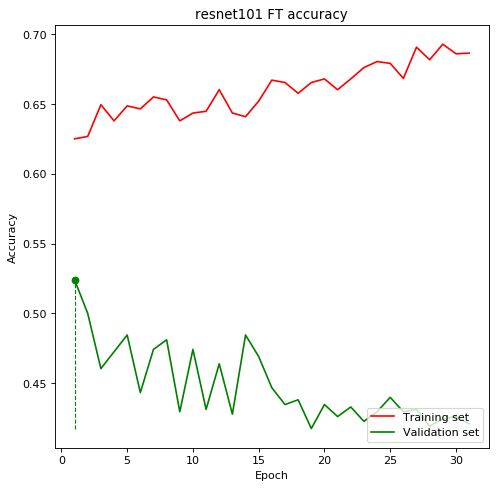

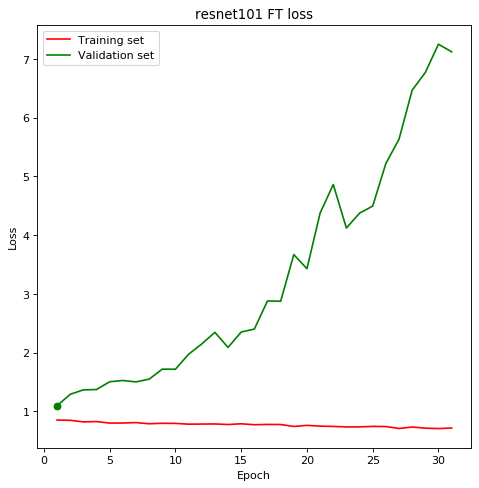

In [11]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('resnet101 FT loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();